In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os
import numpy as np
import zipfile
import os
import tarfile

from scipy import ndimage
from tensorflow.keras import regularizers
from urllib.request import urlretrieve
from scipy.io import loadmat
from __future__ import absolute_import, division, print_function, unicode_literals

tf.keras.backend.set_floatx('float64')

In [2]:
url = "https://storage.googleapis.com/kagglesdsdata/datasets/2418/917074/Sunspots.csv?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1586472062&Signature=CC1HrFyLjRKiYDaHQuTQ6enN0a%2FP%2FLZYhVbIeSHi5zxOsKhNZmWsuCVPOIiZNzv6%2FqjQYTKFD2jNvF1qxtYN%2BKzPH0POT8Q4hjBgF%2BFj4GFVOtWsLP5JJqFzI46u9IZpJrSbnRu7rpIe5D%2FBovopNOpbp0zSpkoTTAIEDMJcQ%2BeRrYdFPKxe8CPr4gou7AzYW%2FC3zxDVxXAO8iJotXGIlkgDuzb2fFR425fNGd69QUFaZl0brcAA5ASywqbutGufRVkiJQWN6ig9t%2B3zvBDy0pf%2F%2FQBsLnCWb791uVSawwfkg8jQeLep%2Fej0%2BMwWXJQovnxNry1WKFe6dpoBQPZrlw%3D%3D&response-content-disposition=attachment%3B+filename%3DSunspots.csv"
sunspots_file = "sunspots.csv"
urlretrieve(url, sunspots_file)

('sunspots.csv', <http.client.HTTPMessage at 0x7f91685500b8>)

In [3]:
import datetime

time_series = []
with open(sunspots_file, "r") as f:
    f.readline()
    for line in f:
        line = line.strip()
        i, date, mean = line.split(',')
        mean = float(mean)
        date = datetime.datetime.strptime(date, "%Y-%m-%d")
        time_series.append((date, mean))

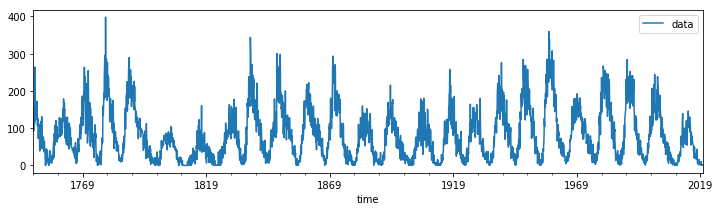

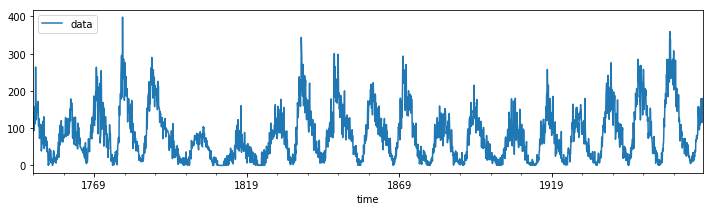

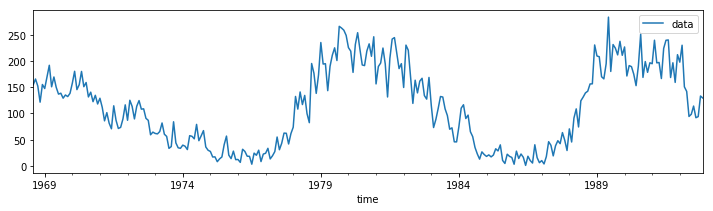

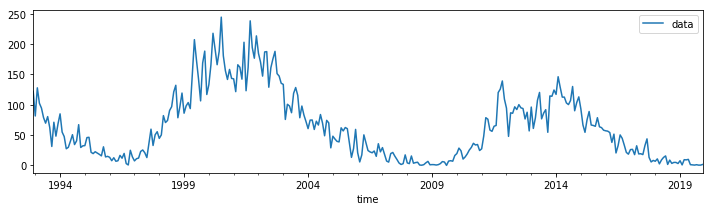

In [36]:
import pandas as pd

df = pd.DataFrame(time_series, columns=['time','data']).set_index('time')
series_len = len(df)
test_len = int(series_len * 0.1)
train_len = series_len - test_len
val_len = int(train_len * 0.1)
train = df.iloc[:-test_len, :]
test = df.iloc[-test_len:, :]
val = train.iloc[-val_len:, :]
train = train.iloc[:-val_len, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)
pred = test.copy()
df.plot(figsize=(12,3))
train.plot(figsize=(12,3))
val.plot(figsize=(12,3))
test.plot(figsize=(12,3))

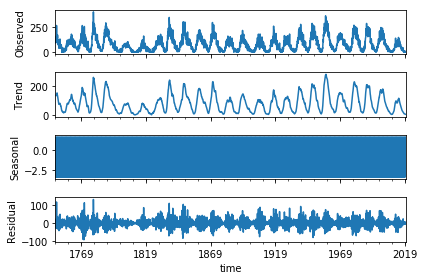

In [6]:
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df)

decomposition.plot()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                   data   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     9.291
Date:                Tue, 07 Apr 2020   Prob (F-statistic):            0.00232
Time:                        14:06:17   Log-Likelihood:                -18026.
No. Observations:                3240   AIC:                         3.606e+04
Df Residuals:                    3238   BIC:                         3.607e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         76.2961      2.217     34.416      0.0

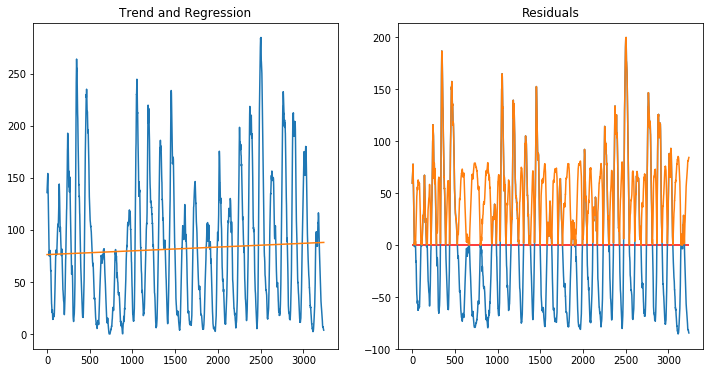

In [7]:
x, y = np.arange(len(decomposition.trend.dropna())), decomposition.trend.dropna()
x = sm.add_constant(x)
model = OLS(y, x)
res = model.fit()
print(res.summary())
fig, ax = plt.subplots(1, 2, figsize=(12,6));
ax[0].plot(decomposition.trend.dropna().values, label='trend')
ax[0].plot([res.params.x1*i + res.params.const for i in np.arange(len(decomposition.trend.dropna()))])
ax[1].plot(res.resid.values);
ax[1].plot(np.abs(res.resid.values));
ax[1].hlines(0, 0, len(res.resid), color='r');
ax[0].set_title("Trend and Regression");
ax[1].set_title("Residuals");

plt.show()

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.data   No. Observations:                 2634
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -12285.029
Method:                       css-mle   S.D. of innovations             25.662
Date:                Tue, 07 Apr 2020   AIC                          24584.057
Time:                        17:46:39   BIC                          24625.191
Sample:                    02-28-1749   HQIC                         24598.951
                         - 07-31-1968                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0153      0.239      0.064      0.949      -0.454       0.485
ar.L1.D.data    -0.4165      0.019    -21.425      0.000      -0.455      -0.378
ar.L2.D.data    -0.2947      0.021    -14.06

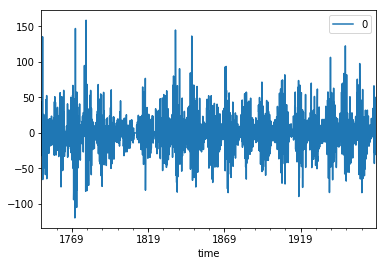

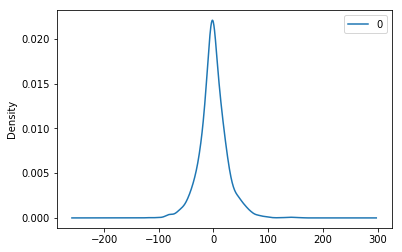

                 0
count  2634.000000
mean      0.005006
std      25.667635
min    -119.657132
25%     -13.076105
50%      -1.047791
75%      12.771107
max     158.609585


In [19]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
 
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [28]:
df.values

array([[ 96.7],
       [104.3],
       [116.7],
       ...,
       [  0.4],
       [  0.5],
       [  1.6]])

In [29]:
X = df.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))

predicted=21.661891, expected=29.100000
predicted=26.045295, expected=22.800000
predicted=22.636237, expected=24.700000
predicted=23.847448, expected=40.300000
predicted=33.142262, expected=35.300000
predicted=32.701709, expected=36.400000
predicted=34.505958, expected=69.000000
predicted=54.207784, expected=64.200000
predicted=55.757911, expected=67.700000
predicted=61.411494, expected=80.200000
predicted=71.255056, expected=72.600000
predicted=69.598493, expected=71.100000
predicted=71.429186, expected=81.200000
predicted=77.311138, expected=81.000000
predicted=78.331441, expected=99.800000
predicted=90.729342, expected=157.000000
predicted=126.774453, expected=132.600000
predicted=121.517356, expected=158.300000
predicted=141.617570, expected=98.400000
predicted=113.016850, expected=122.500000
predicted=123.666885, expected=95.400000
predicted=110.377809, expected=129.500000
predicted=123.179614, expected=151.800000
predicted=139.509736, expected=108.700000
predicted=114.661574, exp

predicted=151.937500, expected=163.700000
predicted=166.834367, expected=139.400000
predicted=152.605745, expected=161.900000
predicted=159.411686, expected=167.400000
predicted=161.832331, expected=134.300000
predicted=141.779313, expected=127.500000
predicted=138.264230, expected=169.000000
predicted=158.443830, expected=115.500000
predicted=130.030718, expected=73.100000
predicted=101.268930, expected=88.700000
predicted=101.716327, expected=109.600000
predicted=107.796418, expected=132.500000
predicted=121.420344, expected=131.500000
predicted=121.858261, expected=108.900000
predicted=110.767270, expected=96.000000
predicted=104.582352, expected=69.900000
predicted=87.845354, expected=72.500000
predicted=84.315673, expected=45.700000
predicted=64.100182, expected=45.600000
predicted=56.649721, expected=74.800000
predicted=69.455307, expected=110.200000
predicted=89.502083, expected=116.700000
predicted=99.282257, expected=90.400000
predicted=89.068524, expected=96.900000
predicted=

/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=99.898659, expected=119.200000
predicted=112.683444, expected=86.000000
predicted=94.583023, expected=98.000000
predicted=99.704017, expected=103.500000
predicted=100.887620, expected=93.600000
predicted=95.791280, expected=149.600000
predicted=128.832480, expected=207.200000
predicted=167.593153, expected=173.500000
predicted=160.233192, expected=142.300000
predicted=148.314582, expected=106.300000
predicted=127.425883, expected=168.700000
predicted=159.531533, expected=188.300000
predicted=174.665332, expected=116.800000
predicted=133.874645, expected=133.100000
predicted=139.119019, expected=165.700000
predicted=155.916072, expected=217.700000
predicted=189.421990, expected=191.500000
predicted=183.097291, expected=165.900000
predicted=169.351842, expected=188.000000
predicted=184.466490, expected=244.300000
predicted=219.313345, expected=180.500000
predicted=190.074145, expected=156.000000
predicted=172.966396, expected=141.600000
predicted=160.926186, expected=158.100000

predicted=67.302167, expected=62.200000
predicted=64.551435, expected=58.000000
predicted=61.834166, expected=57.000000
predicted=59.524006, expected=56.400000
predicted=58.824496, expected=54.100000
predicted=55.904125, expected=37.900000
predicted=45.751563, expected=51.500000
predicted=51.225491, expected=20.500000
predicted=32.799827, expected=32.400000
predicted=35.644953, expected=50.200000
predicted=45.106644, expected=44.600000
predicted=41.416000, expected=33.400000
predicted=36.837925, expected=21.400000
predicted=28.308786, expected=18.500000
predicted=24.935101, expected=26.100000
predicted=27.620382, expected=26.400000
predicted=26.418481, expected=17.700000
predicted=20.665926, expected=32.300000
predicted=28.146875, expected=18.900000
predicted=21.315355, expected=19.200000
predicted=20.919453, expected=17.800000
predicted=20.024409, expected=32.600000
predicted=27.183520, expected=43.700000
predicted=35.714912, expected=13.200000
predicted=19.652468, expected=5.700000
p

NameError: name 'mean_squared_error' is not defined

Test MSE: 538.131


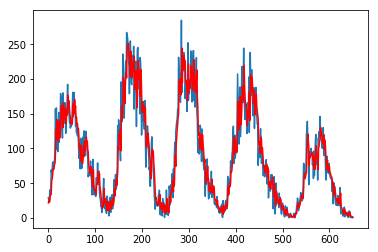

In [30]:
from sklearn.metrics import  mean_squared_error 
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [73]:
def create_dataset(series, time_steps):
    X = []
    y = []
    for i in range(len(series) - time_steps):
        x = series[i:i + time_steps]
        x = np.array(x).reshape(time_steps, 1)
        prediction = series[i + time_steps]
        X.append(x)
        y.append(prediction)
    return np.array(X), np.array(y)

In [74]:
time_steps = 25
x_train, y_train = create_dataset(list(train.values), time_steps)
x_val, y_val = create_dataset(list(val.values), time_steps)
x_test, y_test = create_dataset(list(test.values), time_steps)

In [75]:
x_train.shape

(2610, 25, 1)

In [81]:
from tensorflow.keras import Model, Input, Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, InputLayer, concatenate, SpatialDropout1D, Flatten

batch_size = 32
model = Sequential([
    Bidirectional(LSTM(64), input_shape=(time_steps, 1,)),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               33792     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 42,113
Trainable params: 42,113
Non-trainable params: 0
_________________________________________________________________


In [82]:
history = model.fit(
    x_train, y_train,
    epochs=45,
    batch_size=16,
    validation_data=(x_val, y_val),
    verbose=1
)

Train on 2610 samples, validate on 267 samples
Epoch 1/45
2610/2610 [==============================] - 4s 2ms/sample - loss: 50.6179 - val_loss: 37.0154
Epoch 2/45
2610/2610 [==============================] - 2s 753us/sample - loss: 21.6172 - val_loss: 22.8107
Epoch 3/45
2610/2610 [==============================] - 2s 722us/sample - loss: 19.3826 - val_loss: 20.0015
Epoch 4/45
2610/2610 [==============================] - 2s 724us/sample - loss: 18.7018 - val_loss: 21.7317
Epoch 5/45
2610/2610 [==============================] - 2s 728us/sample - loss: 18.6767 - val_loss: 20.3714
Epoch 6/45
2610/2610 [==============================] - 2s 729us/sample - loss: 18.8620 - val_loss: 21.7290
Epoch 7/45
2610/2610 [==============================] - 2s 751us/sample - loss: 18.2905 - val_loss: 20.0872
Epoch 8/45
2610/2610 [==============================] - 2s 769us/sample - loss: 18.4437 - val_loss: 22.0783
Epoch 9/45
2610/2610 [==============================] - 2s 769us/sample - loss: 18.2295 - v

In [70]:
model.evaluate(x_test, y_test)

305/305 [==============================] - 0s 1ms/sample - loss: 13.3330


13.333021458087597

Test MSE: 383.953


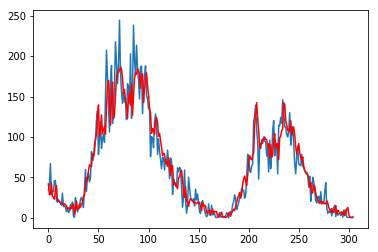

In [72]:
predictions = model.predict(x_test)
error = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % error)
pyplot.plot(y_test)
pyplot.plot(predictions, color='red')
pyplot.show()